## High res ecco - Melville Bay

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import glob
import cartopy
import cartopy.crs as ccrs

In [2]:
geometry = xr.open_dataset("SASSIE_N1_geometry_v3.nc")

In [21]:
geometry

<xarray.Dataset>
Dimensions:  (j: 1080, i: 1440, k: 90)
Coordinates:
    XC       (j, i) float32 ...
    YC       (j, i) float32 ...
    Z        (k) float32 0.5 1.57 2.79 4.185 ... 5.882e+03 6.301e+03 6.76e+03
    Zu       (k) float32 1.0 2.14 3.44 4.93 ... 6.082e+03 6.52e+03 7e+03
    Zl       (k) float32 0.0 1.0 2.14 3.44 ... 5.682e+03 6.082e+03 6.52e+03
Dimensions without coordinates: j, i, k
Data variables:
    hFacC    (k, j, i) float64 ...
    maskC    (k, j, i) int64 ...
    RAC      (j, i) float64 ...
    dX       (j, i) float64 ...
    drF      (k) float64 1.0 1.14 1.3 1.49 1.7 ... 334.6 365.9 400.4 438.2 479.7
Attributes:
    date_created:            2022-04-26T21:59:37
    date_modified:           2022-04-26T21:59:37
    date_metadata_modified:  2022-04-26T21:59:37
    date_issued:             2022-04-26T21:59:37

#### Create netCDFs for theta and salt

In [5]:
ecco_melville_theta_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/THETA/')
ecco_melville_salt_dir = Path('H:/PhD_chap3/data/ECCO_melville/W_Greenland/SALT/')

In [6]:
theta_files = list(ecco_melville_theta_dir.glob('*nc'))
salt_files = list(ecco_melville_salt_dir.glob('*nc'))

In [7]:
## theta
theta_ds = xr.open_mfdataset(theta_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

In [8]:
## salt
salt_ds = xr.open_mfdataset(salt_files,combine='nested',concat_dim='time',parallel=True,\
                            data_vars='all', coords='all')

Need to make a coordinate that combines year, month, and day

In [9]:
def create_time_dt64(ecco_ds):
    time_list = []
    for i in range(len(ecco_ds.time.values)):
        year  = ecco_ds.years.isel(time=i).values
        month = ecco_ds.months.isel(time=i).values
        day   = ecco_ds.days.isel(time=i).values
        
        if month<10 and day<10:
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+'0'+str(day)
        elif month<10 and day>=10: 
            time_tmp = str(year)+'-'+'0'+str(month)+'-'+str(day)
        elif month>=10 and day<10: 
            time_tmp = str(year)+'-'+str(month)+'-'+'0'+str(day)
        else:
            time_tmp = str(year)+'-'+str(month)+'-'+str(day)
        
        time_list.append(time_tmp)
    
    time_dt64 = np.array(time_list, dtype='datetime64')
        
    return time_dt64

In [10]:
time_dt64 = create_time_dt64(theta_ds)

Add new time coordinate to dataset

In [11]:
theta_time_ds = theta_ds.assign_coords({"time":time_dt64})
salt_time_ds  = salt_ds.assign_coords({"time":time_dt64})

Pull out timestep to plot temp and salt

In [66]:
theta_400m = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')
salt_400m  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=400, method='nearest')

theta_250m = theta_time_ds.sel(time="2015-03").mean("time").sel(depth=250, method='nearest')
salt_250m  = salt_time_ds.sel(time="2015-03").mean("time").sel(depth=250, method='nearest')

In [13]:
## make land mask
land_mask = salt_time_ds.isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).SALT.isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

Save subsets

In [35]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_400m.to_netcdf(output_dir + "theta_201503_400m.nc")
salt_400m.to_netcdf(output_dir + "salt_201503_400m.nc")
land_mask.to_netcdf(output_dir + "land_mask.nc")

Make subsets that include lat lon coordinates

In [67]:
theta_201503_400m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').THETA.sel(time="2015-03")
salt_201503_400m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=400, method='nearest').SALT.sel(time="2015-03")

theta_201503_250m = theta_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=250, method='nearest').THETA.sel(time="2015-03")
salt_201503_250m  = salt_time_ds.set_coords('longitude').set_coords('latitude').sel(depth=250, method='nearest').SALT.sel(time="2015-03")

In [26]:
theta_201503_400m.to_netcdf(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m.to_netcdf(output_dir + "salt_201503_400m_latlon.nc")

In [15]:
salt_201503 = salt_time_ds.sel(time="2015-03-01").isel(depth=0)

In [16]:
## make land mask
land_mask = salt_time_ds.set_coords(['longitude','latitude']).isel(time=0).where(salt_time_ds.isel(time=0).SALT==0,drop=True).isel(depth=0)
# make all positive values = 1
land_mask = land_mask.where(land_mask.isnull(), 1)

In [55]:
land_mask.to_netcdf(output_dir + "land_mask_latlon.nc")

#### Plot model domain

Open subsets

In [36]:
output_dir = "C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/02_analyses-and-plots/ecco_melville/slices_nc/"
theta_400m = xr.open_dataset(output_dir + "theta_201503_400m.nc")
salt_400m = xr.open_dataset(output_dir + "salt_201503_400m.nc")
land_mask = xr.open_dataset(output_dir + "land_mask.nc")

theta_201503_400m = xr.open_dataset(output_dir + "theta_201503_400m_latlon.nc")
salt_201503_400m = xr.open_dataset(output_dir + "salt_201503_400m_latlon.nc")
land_mask_latlon = xr.open_dataset(output_dir + "land_mask_latlon.nc")

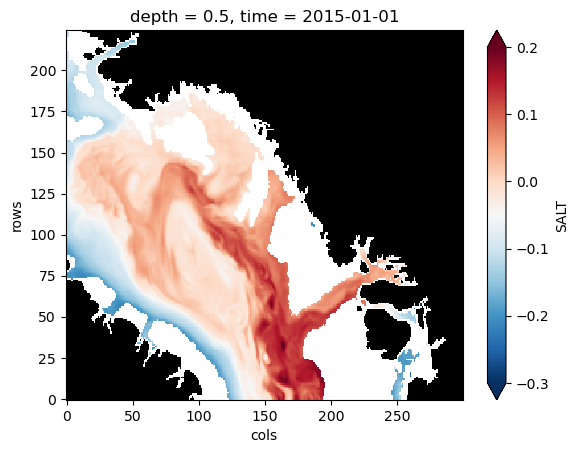

In [37]:
salt_400m_below = salt_400m.SALT.where(salt_400m.SALT>30,drop=True)
(salt_400m_below-salt_400m_below.mean()).plot(vmin=-0.3,vmax=0.2,cmap='RdBu_r')
land_mask.SALT.plot(add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

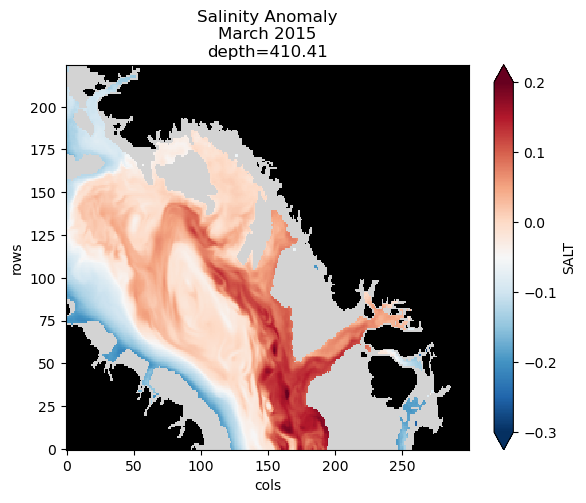

In [38]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

## salt below surface
salt_400m_below = salt_400m.SALT.where(salt_400m.SALT>30,drop=True)

(salt_400m_below-salt_400m_below.mean()).plot(ax=ax1,vmin=-0.3,vmax=0.2,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Salinity Anomaly\nMarch 2015\ndepth=" + str(salt_400m.depth.values));

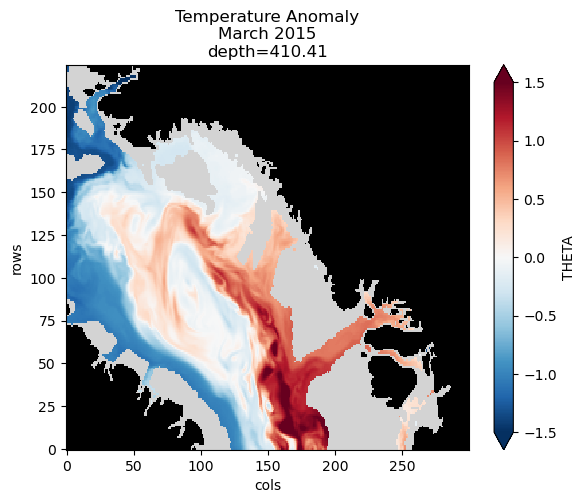

In [39]:
plt.rcParams['figure.figsize'] = [6.5, 5]
fig, ax1 = plt.subplots()

ax1.set_facecolor('lightgray')

theta_400m_below = theta_400m.THETA.where(salt_400m.SALT>30,drop=True)

(theta_400m_below-theta_400m_below.mean()).plot(ax=ax1,vmin=-1.5,vmax=1.5,cmap='RdBu_r')
land_mask.SALT.plot(ax=ax1,add_colorbar=False,cmap='Greys',vmin=-0.5,vmax=1);

ax1.set_title("Temperature Anomaly\nMarch 2015\ndepth=" + str(theta_400m.depth.values));

#### Plot bathymetry over model domain

Load bathymetry data

In [40]:
gebco_bathy = xr.open_dataset("H:/PhD_chap3/data/bathymetry/GEBCO/gebco_2021_n90.0_s30.0_w-120.0_e30.0.nc")

In [41]:
gebco_bathy_select = gebco_bathy.sel(lon=slice(-75,-56),lat=slice(69,76)).elevation.load()

In [87]:
theta_201503_400m_ts0 = theta_201503_400m.isel(time=0)
salt_201503_400m_ts0 = salt_201503_400m.isel(time=0)
theta_400m_below = theta_201503_400m_ts0.where(salt_201503_400m_ts0>30,drop=True)
salt_400m_below = salt_201503_400m_ts0.where(salt_201503_400m_ts0>30,drop=True)

theta_201503_250m_ts0 = theta_201503_250m.isel(time=0)
salt_201503_250m_ts0 = salt_201503_250m.isel(time=0)
theta_250m_below = theta_201503_250m_ts0.where(salt_201503_250m_ts0>30,drop=True)
salt_250m_below = salt_201503_250m_ts0.where(salt_201503_250m_ts0>30,drop=True)

Plot lines for AW boxes over T and S with isobaths

In [75]:
salt_400m_coords = salt_400m.set_coords(['longitude','latitude'])

In [76]:
## subset lines that we extracted for AW boxes
salt_row000_AW_line = salt_400m_coords.isel(rows=0,  cols=slice(190,230))
salt_row025_AW_line = salt_400m_coords.isel(rows=25, cols=slice(160,210))
salt_row050_AW_line = salt_400m_coords.isel(rows=50, cols=slice(145,160))
salt_row075_AW_line = salt_400m_coords.isel(rows=75, cols=slice(150,190))
salt_row100_AW_line = salt_400m_coords.isel(rows=100,cols=slice(125,160))
salt_row125_AW_line = salt_400m_coords.isel(rows=125,cols=slice(120,145))
salt_row150_AW_line = salt_400m_coords.isel(rows=150,cols=slice(125,155))

In [77]:
salt_400m_below_anomaly = (salt_400m_below-salt_400m_below.mean()).load()

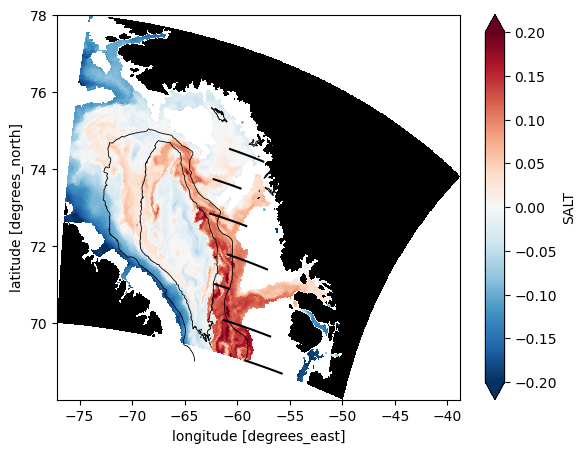

In [78]:
land_mask_latlon.SALT.plot(y='latitude',x='longitude',cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False)
# (salt_400m_coords.SALT.where(salt_400m_coords.SALT>30)).plot(x='longitude',y='latitude',vmin=33.5,vmax=34.6)
salt_400m_below_anomaly.plot(x='longitude',y='latitude',vmin=-0.2,vmax=0.2,cmap='RdBu_r')
gebco_bathy_select.plot.contour(levels=[-2000,-1000],\
                                linestyles='solid',linewidths=0.6,colors='k');

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k')
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k')
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k')
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k')
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k')
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k')
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k')

In [108]:
# fig=plt.figure()
# pc = plt.pcolormesh(salt_400m_coords.longitude,salt_400m_coords.latitude,salt_400m_coords.SALT,vmin=33.5,vmax=34.6)
# fig.colorbar(pc)

ABSOLUTE with row transect lines

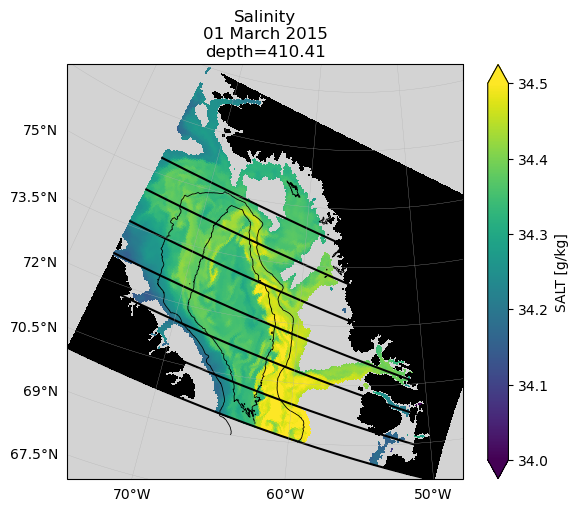

In [81]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

## plot rows over model area
plt.plot(salt_400m_coords.isel(rows=0).longitude, salt_400m_coords.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=25).longitude, salt_400m_coords.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=50).longitude, salt_400m_coords.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=75).longitude, salt_400m_coords.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=100).longitude, salt_400m_coords.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=125).longitude, salt_400m_coords.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=150).longitude, salt_400m_coords.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree())

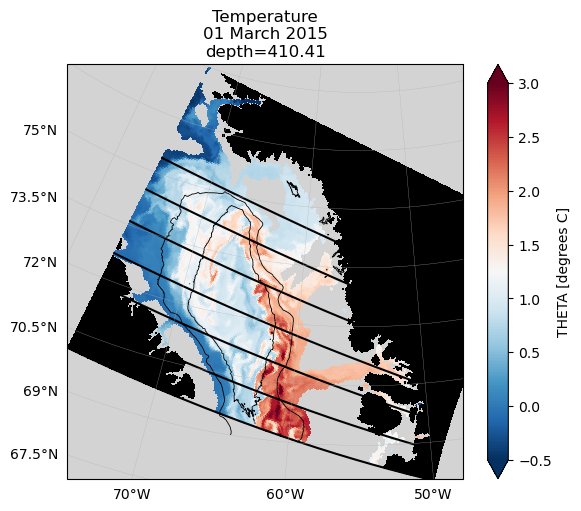

In [59]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_400m_below = theta_201503_400m.THETA.where(salt_201503_400m.SALT>30,drop=True)
# theta_400m_below.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

## plot rows over model area
plt.plot(salt_400m_coords.isel(rows=0).longitude, salt_400m_coords.isel(rows=0).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=25).longitude, salt_400m_coords.isel(rows=25).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=50).longitude, salt_400m_coords.isel(rows=50).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=75).longitude, salt_400m_coords.isel(rows=75).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=100).longitude, salt_400m_coords.isel(rows=100).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=125).longitude, salt_400m_coords.isel(rows=125).latitude, c='k',transform=ccrs.PlateCarree())
plt.plot(salt_400m_coords.isel(rows=150).longitude, salt_400m_coords.isel(rows=150).latitude, c='k',transform=ccrs.PlateCarree())

Plot lines for each box section for AW

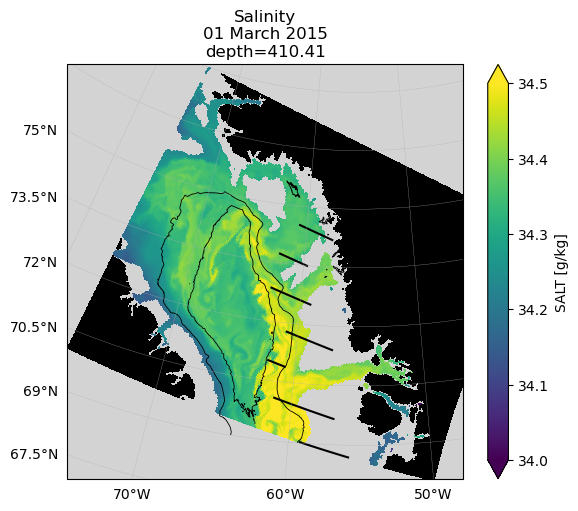

In [65]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

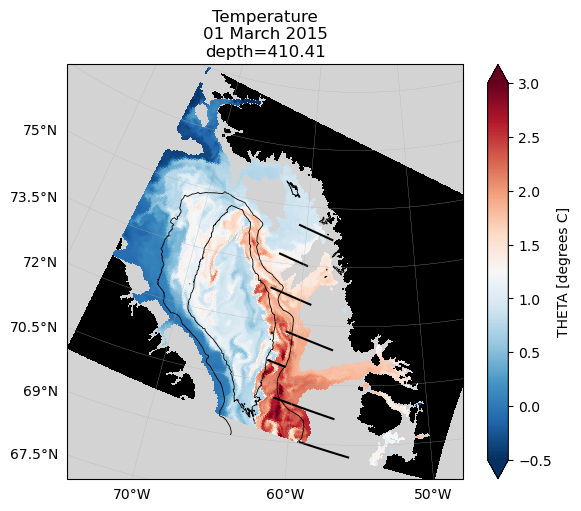

In [64]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

# theta_400m_below = theta_201503_400m.THETA.where(salt_201503_400m.SALT>30,drop=True)
# theta_400m_below.isel(time=0).plot(y='latitude',x='longitude',ax=ax1,transform=ccrs.PlateCarree())

theta_400m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

## 250 m

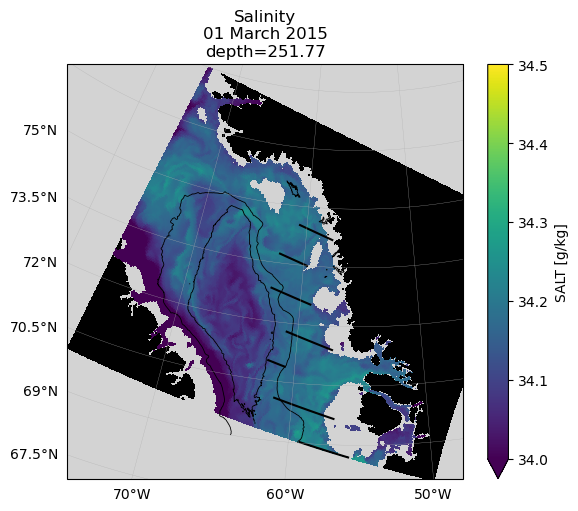

In [88]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_250m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=34,vmax=34.5,transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_250m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity\n01 March 2015\ndepth=" + str(salt_250m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

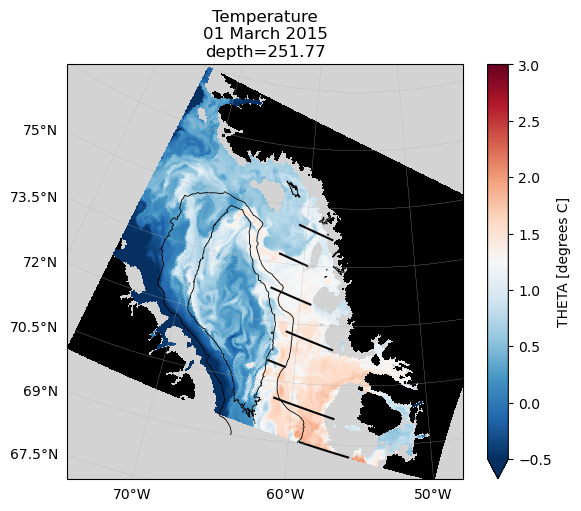

In [85]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

theta_250m_below.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.5,vmax=3,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_250m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature\n01 March 2015\ndepth=" + str(theta_250m.depth.values));

## add lines for what boxes we are selecting along each row
plt.plot(salt_row000_AW_line.longitude,salt_row000_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row025_AW_line.longitude,salt_row025_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row050_AW_line.longitude,salt_row050_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row075_AW_line.longitude,salt_row075_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row100_AW_line.longitude,salt_row100_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row125_AW_line.longitude,salt_row125_AW_line.latitude,c='k',transform=ccrs.PlateCarree())
plt.plot(salt_row150_AW_line.longitude,salt_row150_AW_line.latitude,c='k',transform=ccrs.PlateCarree())

ANOMALY

In [103]:
salt_400m_below_anomaly = (salt_400m_below-salt_400m_below.mean()).load()

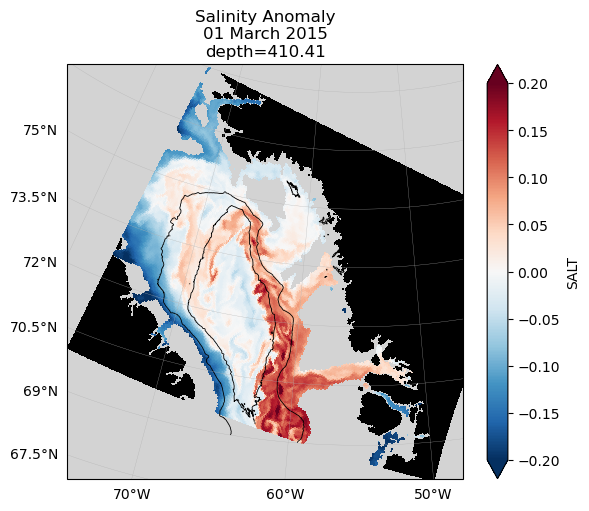

In [86]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

salt_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-0.2,vmax=0.2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Salinity Anomaly\n01 March 2015\ndepth=" + str(salt_400m.depth.values));

In [78]:
theta_400m_below_anomaly = (theta_400m_below-theta_400m_below.mean()).load()

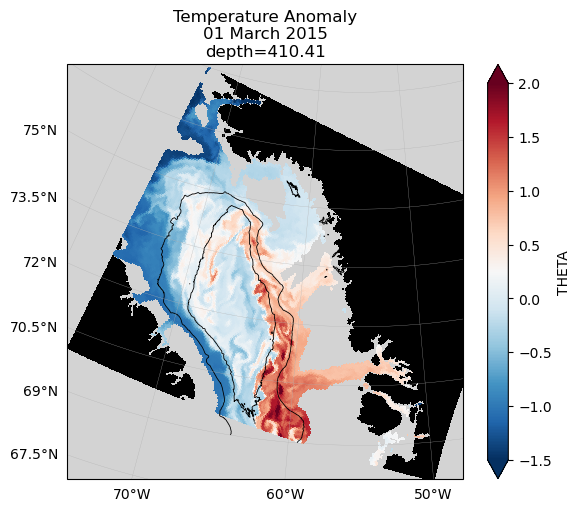

In [87]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -55))
ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

theta_400m_below_anomaly.plot(y='latitude',x='longitude',ax=ax1,vmin=-1.5,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree())
land_mask_latlon.SALT.plot(y='latitude',x='longitude',ax=ax1,cmap='Greys',vmin=-0.5,vmax=1,add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
ax1.set_title("depth=" + str(theta_400m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False

CS = gebco_bathy_select.plot.contour(ax=ax1,levels=[-2000,-1000],\
                                     linestyles='solid',linewidths=0.6,colors='k',\
                                     transform=ccrs.PlateCarree())
# ax1.clabel(CS, CS.levels, inline=True, fontsize=8);
ax1.set_title("Temperature Anomaly\n01 March 2015\ndepth=" + str(theta_400m.depth.values));

#### Take area-weighted mean

In [ ]:
## first switch latitude and longitude from variables to coordinates
theta_ds = theta_time_ds.set_coords(['latitude','longitude'])
salt_ds = salt_time_ds.set_coords(['latitude','longitude'])

In [ ]:
## select data for the three locations (all depths)

## Ummannaq (referred to as 'south')
south_theta_ds = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).THETA
south_salt_ds  = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).SALT

## Upernavik (referred to as 'center')
center_theta_ds = theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).THETA
center_salt_ds  = salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).SALT

## Melville Bay (referred to as 'north')
north_theta_ds = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).THETA
north_salt_ds  = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).SALT

In [ ]:
south_theta_ds=south_theta_ds.load()

In [ ]:
south_theta_ds[:,0,0].plot()

In [ ]:
## take area weighted mean for each location
## cos(lat) is proportional to grid cell area
weights = np.cos(np.deg2rad(south_theta_ds.isel(time=0).latitude))
weights.name = 'weights_cosine_lat'

In [ ]:
## visualize weights - looks good (weights decrease with increasing latitude)
weights.plot();

In [ ]:
south_theta_mean_weighted = (south_theta_ds*weights).sum(dim=["rows","cols"])/weights.sum()

In [ ]:
# compare weighted and unweighted theta for Ummannaq
south_theta_mean_weighted.sel(depth=250, method='nearest').plot()
theta_time_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250, method='nearest').THETA.mean(['rows','cols']).plot(label='Ummannaq')

In [ ]:
## function to take area-weighted mean
def area_weighted_mean(ds):
    ## take area weighted mean for each location
    ## cos(lat) is proportional to grid cell area
    weights = np.cos(np.deg2rad(ds.isel(time=0).latitude))
    weights.name = 'weights_cosine_lat'
        
    ## take mean
    ds_mean_weighted = (ds*weights).sum(dim=["rows","cols"])/weights.sum()
    
    return ds_mean_weighted

In [ ]:
## take area-weighted mean for three locations

## Ummannaq (referred to as 'south')
south_theta_mean_weighted = area_weighted_mean(south_theta_ds)
south_salt_mean_weighted  = area_weighted_mean(south_salt_ds)

## Upernavik (referred to as 'center')
center_theta_mean_weighted = area_weighted_mean(center_theta_ds)
center_salt_mean_weighted  = area_weighted_mean(center_salt_ds)

## Melville Bay (referred to as 'north')
north_theta_mean_weighted = area_weighted_mean(north_theta_ds)
north_salt_mean_weighted  = area_weighted_mean(north_salt_ds)

#### Plot profiles of three regions

Melville Bay

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
north_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

Upernavik

In [ ]:
center_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
center_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

Ummannaq

In [ ]:
south_theta_mean_weighted.plot(y='depth',cmap='RdYlBu_r',vmin=-2,vmax=3);
plt.ylim(1000,0);

In [ ]:
south_salt_mean_weighted.plot(y='depth',cmap='viridis',vmin=33,vmax=34.4);
plt.ylim(1000,0);

#### Plot time series of three regions

In [ ]:
## select data for the three locations (250 m depth)

## Ummannaq (referred to as 'south')
south_theta_ds = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').THETA
south_salt_ds  = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').SALT

## Upernavik (referred to as 'center')
center_theta_ds = theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').THETA
center_salt_ds  = salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').SALT

## Melville Bay (referred to as 'north')
north_theta_ds = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').THETA
north_salt_ds  = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').SALT

In [ ]:
## take area-weighted mean for three locations

## Ummannaq (referred to as 'south')
south_theta_mean_weighted = area_weighted_mean(south_theta_ds)
south_salt_mean_weighted  = area_weighted_mean(south_salt_ds)

## Upernavik (referred to as 'center')
center_theta_mean_weighted = area_weighted_mean(center_theta_ds)
center_salt_mean_weighted  = area_weighted_mean(center_salt_ds)

## Melville Bay (referred to as 'north')
north_theta_mean_weighted = area_weighted_mean(north_theta_ds)
north_salt_mean_weighted  = area_weighted_mean(north_salt_ds)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_theta_mean_250m.plot(label='Melville Bay')
center_theta_mean_250m.plot(label='Upernavik')
south_theta_mean_250m.plot(label='Ummannaq')
plt.ylabel("Theta (deg C)")
plt.legend()
plt.grid();

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
north_salt_mean_250m.plot(label='Melville Bay')
center_salt_mean_250m.plot(label='Upernavik')
south_salt_mean_250m.plot(label='Ummannaq')
plt.ylabel("Salinity")
plt.legend()
plt.grid();

This runs WAY faster

In [ ]:
# melville bay salinity
salt_ds_melville = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
salt_ds_melville.plot()

In [ ]:
# temperature
theta_ds_melville = theta_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA
theta_ds_upernavik= theta_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA
theta_ds_ummannaq = theta_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).THETA

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
theta_ds_melville.plot(label="melville")
theta_ds_upernavik.plot(label="upernavik")
theta_ds_ummannaq.plot(label="ummannaq")
plt.legend()
plt.grid();

In [ ]:
# salinity
salt_ds_melville = salt_ds.isel(cols=slice(125-5,125+5),rows=slice(150-5,150+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT
salt_ds_upernavik= salt_ds.isel(cols=slice(150-5,150+5),rows=slice(110-5,110+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT
salt_ds_ummannaq = salt_ds.isel(cols=slice(180-5,180+5),rows=slice(50-5,50+5)).sel(depth=250,method='nearest').mean(dim=['cols','rows']).SALT

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
salt_ds_melville.plot(label="melville")
salt_ds_upernavik.plot(label="upernavik")
salt_ds_ummannaq.plot(label="ummannaq")
plt.legend()
plt.grid();

Group data by month and plot

In [ ]:
north_theta_mean_12M  = north_theta_mean_250m.groupby("time.month").mean("time")
center_theta_mean_12M = center_theta_mean_250m.groupby("time.month").mean("time")
south_theta_mean_12M  = south_theta_mean_250m.groupby("time.month").mean("time")

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]
north_theta_mean_12M.plot(label='Melville Bay')
center_theta_mean_12M.plot(label='Upernavik')
south_theta_mean_12M.plot(label='Ummannaq')
plt.ylim(0.6,1.8)
plt.ylabel("Theta (deg C)")
plt.legend(loc='lower right')
plt.grid();

In [ ]:
north_salt_mean_12M  = north_salt_mean_250m.groupby("time.month").mean("time")
center_salt_mean_12M = center_salt_mean_250m.groupby("time.month").mean("time")
south_salt_mean_12M  = south_salt_mean_250m.groupby("time.month").mean("time")

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]
north_salt_mean_12M.plot(label='Melville Bay')
center_salt_mean_12M.plot(label='Upernavik')
south_salt_mean_12M.plot(label='Ummannaq')
plt.ylabel("Salinity")
plt.legend(loc='lower right')
plt.grid();

### Additional exploratory plots

In [ ]:
salt_tmp = salt_ds.isel(time=0)

In [ ]:
temp_ds_masked = theta_ds.THETA.where(salt_tmp.SALT>30)
salt_ds_masked = salt_ds.SALT.where(salt_tmp.SALT>30)

In [ ]:
plt.rcParams['figure.figsize'] = [11, 4]
fig, axs = plt.subplots(1,2)
ax1,ax2 = axs.ravel()
temp_ds_masked.sel(time='2016-07-01',depth=250,method='nearest').plot(ax=ax1)
salt_ds_masked.sel(time='2016-07-01',depth=250,method='nearest').plot(ax=ax2,vmin=33,vmax=34.4);

##### March

In [ ]:
plt.rcParams['figure.figsize'] = [7, 10]
plt.rcParams['font.size'] = '10'
fig, axs = plt.subplots(4,2,constrained_layout=True)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

labels=['2015','2015','2016','2016','2017','2017','2018','2018']
for ax,label in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8),labels):
    ax.set_title(label)
    
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)

fig.suptitle("March")

##### December

In [ ]:
plt.rcParams['figure.figsize'] = [7, 10]
plt.rcParams['font.size'] = '10'
fig, axs = plt.subplots(4,2,constrained_layout=True)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-12-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-12-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-12-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-12-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-12-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-12-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-12-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-12-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

labels=['2015','2015','2016','2016','2017','2017','2018','2018']
for ax,label in zip((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8),labels):
    ax.set_title(label)
    
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)

fig.suptitle("December")

In [ ]:
plt.rcParams['figure.figsize'] = [11.5, 19]
fig, axs = plt.subplots(4,2)
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = axs.ravel()

temp_min=-4
temp_max=4
salt_min=33
salt_max=34.4

temp_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax1,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2015-03-01',depth=250,method='nearest').plot(ax=ax2,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax3,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2016-03-01',depth=250,method='nearest').plot(ax=ax4,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax5,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2017-03-01',depth=250,method='nearest').plot(ax=ax6,vmin=salt_min,vmax=salt_max)

temp_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax7,cmap='RdBu_r',vmin=temp_min,vmax=temp_max)
salt_ds_masked.sel(time='2018-03-01',depth=250,method='nearest').plot(ax=ax8,vmin=salt_min,vmax=salt_max);

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8):
    ## add rectangles to demarcate regions used in time series
    # Create a Rectangle patch
    rect_ummannaq  = patches.Rectangle((180-5, 50-5),  10, 10, linewidth=1, edgecolor='k', facecolor='none') # Ummannaq
    rect_upernavik = patches.Rectangle((145-5, 110-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Upernavik
    rect_melville  = patches.Rectangle((125-5, 150-5), 10, 10, linewidth=1, edgecolor='k', facecolor='none') # Melville Bay
    
    ax.add_patch(rect_ummannaq)
    ax.add_patch(rect_upernavik)
    ax.add_patch(rect_melville)